# 1. Environment Set

In [1]:
# chidir to google drive
from google.colab import drive
drive.mount('/content/drive')

# path set
import os
BASE_PATH = '/content/drive/My Drive/colab_files/cifar10_CNN/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = BASE_PATH

#import package
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import os
import torch.nn.functional as F
import torch.optim as optim
import sys
sys.path.append(BASE_PATH)

Mounted at /content/drive


# 2. Data Loader

In [2]:
transform_train = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

transform_test = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

data_train = datasets.CIFAR10(root=DATA_PATH, train=True, download=True, transform=transform_train)
data_test = datasets.CIFAR10(root=DATA_PATH, train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


# 3.Network


In [3]:
class ResBlock(nn.Module):
  def __init__(self, inchannel, outchannel, stride):
    super(ResBlock, self).__init__()
    self.halfpath = nn.Sequential(
        nn.Conv2d(inchannel, outchannel, 3, stride, 1),
        nn.BatchNorm2d(outchannel),
        nn.ReLU(),
        nn.Conv2d(outchannel, outchannel, 3, 1, 1),
        nn.BatchNorm2d(outchannel)
    )
    self.shortcut = nn.Sequential()
    if stride != 1:
      self.shortcut = nn.Sequential(
          nn.Conv2d(inchannel, outchannel, 1, 2, 0),
          nn.BatchNorm2d(outchannel)
      )

  def forward(self, x):

    fw = self.halfpath(x)
    fw += self.shortcut(x)
    fw = F.relu(fw)
    return fw


class ResNet18(nn.Module):
  def __init__(self):
    super(ResNet18, self).__init__()
    self.current_channels = 64
    self.pre = nn.Sequential(
        nn.Conv2d(3, 64, 7, 2, 3),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(3, 2, 1)
    )
    #self.block = ResBlock
    self.layer1 = self.make_layers(64, 1)
    self.layer2 = self.make_layers(128, 2)
    self.layer3 = self.make_layers(256, 2)
    self.layer4 = self.make_layers(512, 2)
    self.fc = nn.Linear(512, 10)

  def make_layers(self,output_channels, stride):
    layers = []
    strides = [stride, 1]
    for s in strides:
      block = ResBlock(self.current_channels, output_channels, s)
      layers.append(block)
      self.current_channels = output_channels
    return nn.Sequential(*layers)


  def forward(self, x):
    forw = self.pre(x)
    # print(forw.shape)
    forw = self.layer1(forw)
    forw = self.layer2(forw)
    forw = self.layer3(forw)
    forw = self.layer4(forw)
    # print(forw,type(forw))
    forw = F.avg_pool2d(forw,7)
    forw = forw.view(forw.size(0), -1)
    forw = self.fc(forw)
    return forw

# 4.Training

Device cuda..Epoch 1/150.. Step 200.. Train loss: 2.021.. Test loss: 1.756.. Test accuracy: 0.364
Device cuda..Epoch 2/150.. Step 400.. Train loss: 1.783.. Test loss: 1.530.. Test accuracy: 0.438
Device cuda..Epoch 2/150.. Step 600.. Train loss: 1.680.. Test loss: 1.444.. Test accuracy: 0.469
Device cuda..Epoch 3/150.. Step 800.. Train loss: 1.587.. Test loss: 1.469.. Test accuracy: 0.467
Device cuda..Epoch 3/150.. Step 1000.. Train loss: 1.518.. Test loss: 1.294.. Test accuracy: 0.531
Device cuda..Epoch 4/150.. Step 1200.. Train loss: 1.459.. Test loss: 1.209.. Test accuracy: 0.566
Device cuda..Epoch 4/150.. Step 1400.. Train loss: 1.395.. Test loss: 1.228.. Test accuracy: 0.571
Device cuda..Epoch 5/150.. Step 1600.. Train loss: 1.351.. Test loss: 1.046.. Test accuracy: 0.624
Device cuda..Epoch 5/150.. Step 1800.. Train loss: 1.304.. Test loss: 1.102.. Test accuracy: 0.613
Device cuda..Epoch 6/150.. Step 2000.. Train loss: 1.260.. Test loss: 1.011.. Test accuracy: 0.644
Device cuda..E

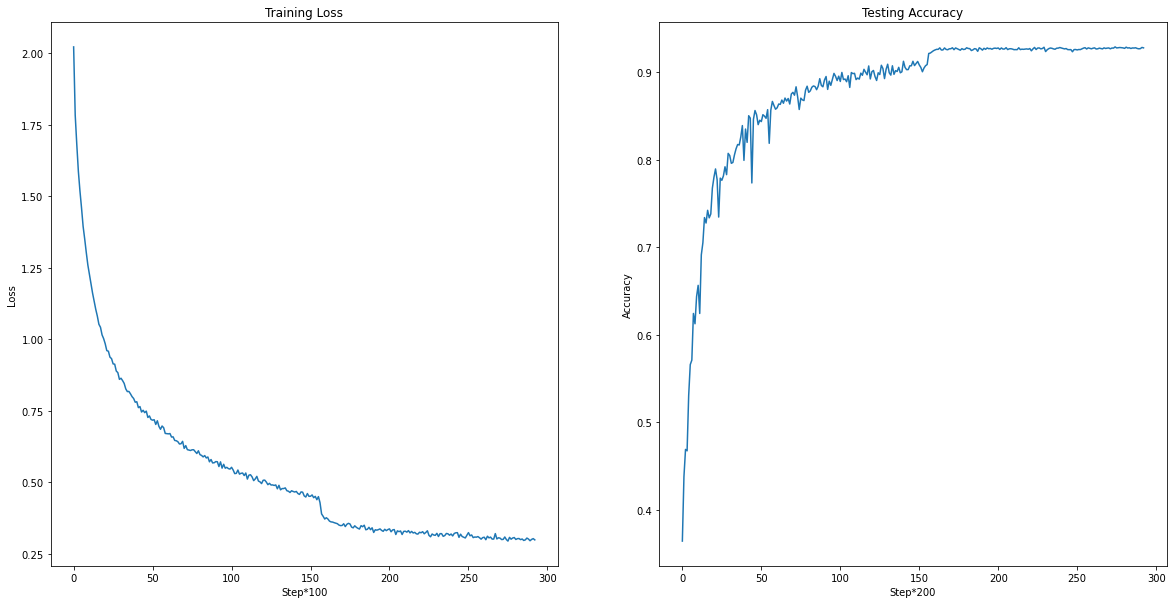

In [4]:
import os
import torchvision.datasets as datasets
import torch
import torch.nn as nn
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
import numpy as np
import os
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot as plt

def plot_results(train_losses, test_accuracies):
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    axes[0].plot(train_losses)
    axes[0].set_title('Training Loss')
    axes[0].set_xlabel('Step*100')
    axes[0].set_ylabel('Loss')
    
    axes[1].plot(test_accuracies)
    axes[1].set_title('Testing Accuracy')
    axes[1].set_xlabel('Step*200')
    axes[1].set_ylabel('Accuracy')


trainloader = DataLoader(data_train, batch_size=128, shuffle=True)
testloader = DataLoader(data_test, batch_size=128)
device = 'cuda'

## need change
model = ResNet18()
# model= ResBlock(3,10,1)
# print(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)


model.to(device)
from tqdm import tqdm

traininglosses = []
testinglosses = []
testaccuracy = []
totalsteps = []
#change the epochs if the test accuracy is low
epochs = 150
steps = 0
running_loss = 0
print_every = 200
for epoch in range(epochs):
    if epoch == 80:
      optimizer = optim.SGD(model.parameters(), lr=0.01)
    if epoch == 130:
      optimizer = optim.SGD(model.parameters(), lr=0.001)
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        # print(inputs.shape,labels.shape)
        logps = model(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        # Print the result every 200 steps
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
            traininglosses.append(running_loss/print_every)
            testinglosses.append(test_loss/len(testloader))
            testaccuracy.append(accuracy/len(testloader))
            totalsteps.append(steps)
            print(f"Device {device}.."
                  f"Epoch {epoch+1}/{epochs}.. "
                  f"Step {steps}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()
plot_results(traininglosses, testaccuracy)